In [3]:
import os
from diffusers.utils import load_image
import json
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

input_path = "./data/"
output_path = "./data_test/"

filelist = [i for i in os.listdir(input_path) if i.endswith(".jpg")]
masklist = [i for i in os.listdir(output_path) if i.endswith(".pt")]
infolist = [i for i in os.listdir(output_path) if i.endswith("info.json")]


### command

python scripts/main_ssa_perso.py --ckpt_path ./ckp/sam_vit_h_4b8939.pth --save_img --world_size 1 --dataset ade20k --data_dir data/ --out_dir ./data_test

In [4]:
def load_info(infopath):
    with open(infopath, "r") as f:
        info = json.load(f)
    return info

def load_mask(maskpath):
    mask = torch.load(maskpath)
    return mask



red : wall
green : floor
blue : ceiling
yellow : windowpane
cyan : cabinet
magenta : door
white : table
black : plant
orange : chair
purple : painting
red : sofa
green : fireplace
blue : stairs
yellow : stairway
cyan : coffee table
magenta : television receiver
white : bottle
black : stool
orange : pot
purple : sculpture
red : tray
green : clock


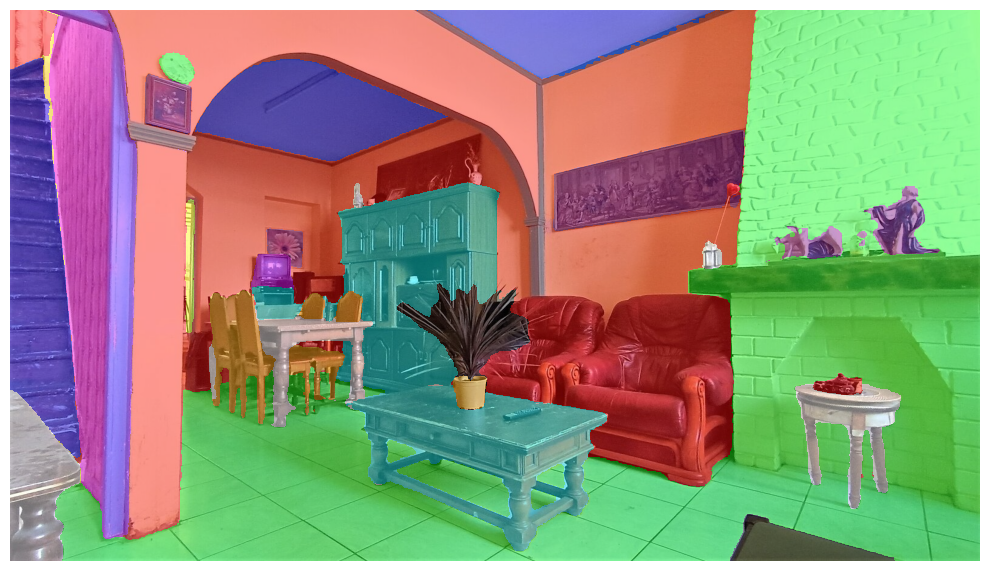

In [5]:
img = filelist[0]
mask = masklist[0]
infopath = infolist[0]

theimage = load_image(os.path.join(input_path, img))  # load_image returns a PIL Image
masks = load_mask(os.path.join(output_path, mask))  # masks is a list of tensors
info = load_info(os.path.join(output_path, infopath))  # info is a dictionary

image_np = np.array(theimage)  # shape (H, W, 3), dtype uint8

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image_np)
ax.axis('off')

color_rgb = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255), (255, 255, 255), (0, 0, 0), (255, 165, 0), (128, 0, 128)]
color_name = ["red", "green", "blue", "yellow", "cyan", "magenta", "white", "black", "orange", "purple"]

# Overlay each mask
for i, m in enumerate(masks):
    m_np = m.cpu().numpy()        # shape (H, W), values 0 or 1
    H, W = m_np.shape

    # pick a random RGB color
    color = color_rgb[i%len(color_rgb)]
    print(f"{color_name[i%len(color_name)]} : {info['semantic_class_names'][i]}")

    # build an RGBA image where the mask pixels get that color+alpha
    alpha = 0.4  # you can vary this per-mask if you like
    overlay = np.zeros((H, W, 4), dtype=np.uint8)
    overlay[..., :3] = color
    overlay[...,  3] = (m_np * alpha * 255).astype(np.uint8)

    ax.imshow(overlay, interpolation='none')

plt.tight_layout()
plt.show()

In [ ]:
def find_mask_index(info, masks,maskname):
    if maskname not in info["semantic_class_names"]:
        print(f"Mask {maskname} not found in info")
        return None, None
    mask_info = info["semantic_class_names"].index(maskname)
    mask= masks[mask_info]
    return mask,mask_info

In [ ]:
walls = info["semantic_class_names"].index("wall")
walls_mask = masks[walls]

# save the walls mask :
walls_mask_path = f"{output_path}/1_walls_mask.png"
Image.fromarray(walls_mask.cpu().numpy() * 255).save(walls_mask_path)

In [ ]:
floor = info["semantic_class_names"].index("floor")
floor_mask = masks[floor]

floor_mask_path = f"{output_path}/1_floor_mask.png"
Image.fromarray(floor_mask.cpu().numpy() * 255).save(floor_mask_path)

In [ ]:
ceiling = info["semantic_class_names"].index("ceiling")

ceiling_mask = masks[ceiling]

In [ ]:
# combine wall, floor and ceiling masks :
combined_mask = walls_mask | floor_mask | ceiling_mask

# save the combined mask :
combined_mask_path = f"{output_path}/1_combined_mask.png"
Image.fromarray(combined_mask.cpu().numpy() * 255).save(combined_mask_path)

In [ ]:
for maskfile, infofile in zip(masklist, infolist):
    print(infofile)
    maskpath = "../data/output/" + maskfile
    infopath = "../data/output/" + infofile
    final_filename = infofile.replace("info.json", "")
    infos = load_info(infopath)
    masks = load_mask(maskpath)
    for element in ["wall", "floor", "ceiling", "windowpane"]:
        mask, mask_info = find_mask_index(infos, masks, element)
        if mask is not None and mask_info is not None:
            mask_path = "../data/output/" + final_filename + element + "_mask.png"
            try:
                Image.fromarray(mask.cpu().numpy() * 255).save(mask_path)
            except Exception as e:
                print("error saving mask ", mask_path)
                print(mask)
                print(e)
